# Asymptotically exact data augmentation: models, properties and algorithms

This notebook reproduces the results depicted in the tables and figures of the companion paper: 

M. Vono et al., **Asymptotically exact data augmentation: models, properties and algorithms**, *Journal of Computational and Graphical Statistics* (in press), 2020.

**Table of contents** 

[Figure 2: Behavior of the non-asymptotic bounds](#Figure-2) 

[Figure 3: Univariate Gaussian distribution](#Figure-3) 

[Figure 4: Analysis of the quantitative bounds on 2-Wasserstein and total variation distances](#Figure-4)

[Figure 5: Illustration of AXDA on the lasso problem](#Figure-5)  

[Table 2: Illustration of AXDA on the lasso problem](#Table-2)  

[Figure 2 in supplementary material: Illustration of AXDA with Lipschitz loss functions](#Figure-2-in-supplementary-material)

[Figure 3 in supplementary material: Illustration of AXDA with Lipschitz loss functions](#Figure-3-in-supplementary-material) 

[Figure 6: Image inpainting example](#Figure-6)

[Figure 7: Image inpainting example](#Figure-7) 

In [1]:
# Figure rendering -----------------------
%pylab inline
figsize(5,5) 

# Import required packages -----------------------
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
import matplotlib as mpl
from matplotlib import cm, rc
from scipy import special
import scipy.integrate as integrate
from scipy.linalg import sqrtm
from IPython.display import Latex, display
from scipy.io import loadmat
from mpl_toolkits.axes_grid1 import make_axes_locatable

# If wanted, uncomment the 2 following lines to set latex font -----------------------
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)
#params= {'text.latex.preamble' : [r'\usepackage{amssymb}']}
#plt.rcParams.update(params)

# Set random seed -----------------------
random.seed(1)

Populating the interactive namespace from numpy and matplotlib


In [28]:
# Multivariate Gaussian sampling with Cholesky factorization -----------------------
def sampler_factorization(mu,A,mode="precision",method="Cholesky",size=1):
    r"""
    Algorithm dedicated to sample from a multivariate real-valued Gaussian 
    distribution :math:`\mathcal{N}(\boldsymbol{\mu},\mathbf{A})` or 
    :math:`\mathcal{N}(\boldsymbol{\mu},\mathbf{A}^{-1})` based on matrix
    factorization (e.g., Cholesky or square root).
    
    Parameters
    ----------
    mu : 1-D array_like, of length d
        Mean of the d-dimensional Gaussian distribution.
    A : 2-D array_like, of shape (d, d)
        Covariance or precision matrix of the distribution. It must be 
        symmetric and positive-definite for proper sampling.
    mode : string, optional
        Indicates if A refers to the precision or covariance matrix of the
        Gaussian distribution.
    method : string, optional
        Factorization method. Choose either 'Cholesky' or 'square-root'.
    size : int, optional
        Given a size of for instance T, T independent and identically 
        distributed (i.i.d.) samples are returned.
        
    Returns
    -------
    theta : ndarray, of shape (d,size)
        The drawn samples, of shape (d,size), if that was provided. If not, 
        the shape is (d,1).
        
    Raises
    ------
    ValueError
        If A is not positive definite and symmetric.
        If mode is not included in ['covariance','precision'].
        If method is not included in ['Cholesky','square-root'].
        
    Examples
    --------
    >>> d = 2
    >>> mu = np.zeros(d)
    >>> A = np.eye(d)
    >>> mode = "covariance"
    >>> method = "Cholesky"
    >>> size = 1
    >>> theta = sampler_factorization(mu,A,mode=mode,method=method,size=size)
    """ 
    
    d = len(mu)
        
    if mode == "precision":
        # Check if the matrix is definite positive
        if np.all(np.linalg.eigvals(A) > 0) == False:
            raise ValueError('''The "{}" matrix is singular. Fix its positive definiteness.'''.format(mode))
        else:
            if method == "Cholesky":
                C = np.linalg.cholesky(A)
                z = np.random.normal(loc=0,scale=1,size=(np.size(A,0),size))
                return np.reshape(mu,(d,1)) \
                       + np.reshape(solve_triangular(C.T,z,lower=False),(d,size))
            elif method == "square-root":
                B = sqrtm(A)
                z = np.random.normal(loc=0,scale=1,size=(np.size(A,0),size))
                return np.reshape(mu,(d,1)) \
                       + np.reshape(np.linalg.solve(B,z),(d,size))
            else:
                str_list = ['Invalid method input, choose among:',
                    '- "Cholesky" (default)',
                    '- "square-root"',
                    'Given "{}"'.format(mode)]
                raise ValueError('\n'.join(str_list))
                
        
    elif mode == "covariance":
         # Check if the matrix is definite positive
        if np.all(np.linalg.eigvals(A) > 0) == False:
            raise ValueError('''The "{}" matrix is singular. Fix its positive definiteness.'''.format(mode))
        else:
            if method == "Cholesky":
                C = np.linalg.cholesky(A)
                z = np.random.normal(loc=0,scale=1,size=(np.size(A,0),size))
                return np.reshape(mu,(d,1)) + np.reshape(C.dot(z),(d,size))
            elif method == "square-root":
                B = sqrtm(A)
                z = np.random.normal(loc=0,scale=1,size=(np.size(A,0),size))
                return np.reshape(mu,(d,1)) + np.reshape(B.dot(z),(d,size))
            else:
                str_list = ['Invalid method input, choose among:',
                    '- "Cholesky" (default)',
                    '- "square-root"',
                    'Given "{}"'.format(mode)]
                raise ValueError('\n'.join(str_list))
      
        
    else:
        str_list = ['Invalid mode input, choose among:',
                    '- "precision" (default)',
                    '- "covariance"',
                    'Given "{}"'.format(mode)]
        raise ValueError('\n'.join(str_list))

## Figure 2

Text(0, 0.5, 'Upper bound - Theorem 2')

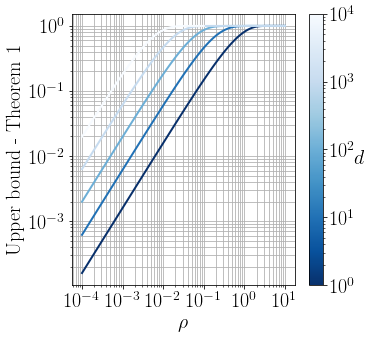

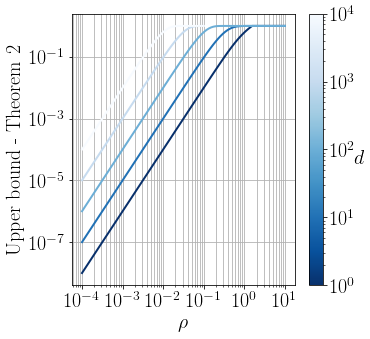

In [30]:
# Upper bound appearing in Theorem 1 ===========================

# Parameters -----------------------
Lf = 1 
rho1 = np.logspace(-4,-1,1e2)
rho2 = np.logspace(-4,1,1e2)
d = [1,1e1,1e2,1e3,1e4] 

# Colorbar settings -----------------------
normc = mpl.colors.LogNorm(np.min(d),np.max(d))
colors = mpl.cm.Blues_r
col = cm.Blues_r(np.logspace(1,6,100))
s = mpl.cm.ScalarMappable(cmap=colors, norm=normc)
s.set_array([])

# Plot the upper bound -----------------------
res = np.zeros((len(d),len(rho2)))
plt.figure()
for j in range(len(d)):
    UB = []
    if j >= 4:
        for i in range(len(rho1)):
            UB.append(1 - mp.pcfd(-d[j],Lf*rho1[i]) / mp.pcfd(-d[j],-Lf*rho1[i]))
        res[j,range(len(rho1))] = UB 
        plt.plot(rho1, UB, lw=2, color=colors(normc(d[j])))
    else:
        for i in range(len(rho2)):
            UB.append(1 - mp.pcfd(-d[j],Lf*rho2[i]) / mp.pcfd(-d[j],-Lf*rho2[i]))
        res[j,] = UB   
        plt.plot(rho2, UB, lw=2, color=colors(normc(d[j])))
        
cb1 = plt.colorbar(s,ticklocation = 'left')  
cb1.set_label(r'$d$', rotation=0,size=20)
cb1.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both')
plt.xlabel(r"$\rho$",size=20)
plt.ylabel(r"Upper bound - Theorem 1",size=20)

# Upper bound appearing in Theorem 2 ===========================

# Plot the upper bound -----------------------
res = np.zeros((len(d),len(rho2)))
plt.figure()
for j in range(len(d)):
    UB = []
    if j >= 3:
        for i in range(len(rho1)):
            UB.append(1 - (1 - (rho1[i]**4 / (1 + 2*rho1[i]**2))) / (1 + 2*rho1[i]**2)**(d[j]/2))
        res[j,range(len(rho1))] = UB 
        plt.plot(rho1, np.minimum(UB,1), lw=2, color=colors(normc(d[j])))
    else:
        for i in range(len(rho2)):
            UB.append(1 - (1 - (rho2[i]**4 / (1 + 2*rho2[i]**2))) / (1 + 2*rho2[i]**2)**(d[j]/2))
        res[j,range(len(rho2))] = UB 
        plt.plot(rho2, np.minimum(UB,1), lw=2, color=colors(normc(d[j])))
    
cb1 = plt.colorbar(s,ticklocation = 'left')
cb1.set_label(r'$d$', rotation=0,size=20)
cb1.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both')
plt.xlabel(r"$\rho$",size=20)
plt.ylabel(r"Upper bound - Theorem 2",size=20)

## Figure 3

Text(0.5, 1.0, 'Uniform kernel')

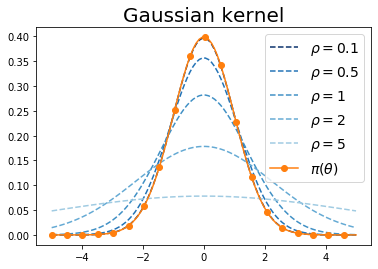

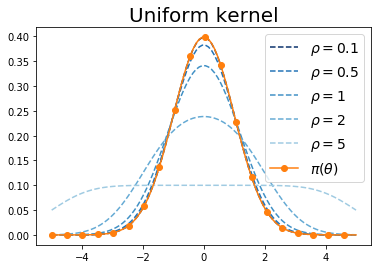

In [3]:
# Parameters -----------------------
var = 1
rho = [0.1 * np.sqrt(var),0.5 * np.sqrt(var),np.sqrt(var),2 * np.sqrt(var),5 * np.sqrt(var)]
R = len(rho)
var_rho = var + np.array(rho)**2

# Color rendering -----------------------
normc = mpl.colors.LogNorm(np.min(rho),np.max(rho)*10)
colors = mpl.cm.Blues_r
col = cm.Blues_r(np.logspace(np.log(np.min(rho)),np.log(np.max(rho)*10),100))
s = mpl.cm.ScalarMappable(cmap=colors, norm=normc)
s.set_array([]) 

# Gaussian smoothing kernel ===========================
num = 100
theta = np.linspace(-5,5,num)

pi = np.exp(- theta**2 / (2 * var)) / np.sqrt(2 * np.pi * var)
pi_rho = np.zeros((num,R))
for i in range(R):
    pi_rho[:,i] = np.exp(- theta**2 / (2 * var_rho[i])) / np.sqrt(2 * np.pi * var_rho[i])   

# Plot -----------------------
plt.figure()
plt.plot(theta,pi_rho[:,0],'--',label=r'$\rho = 0.1$',color=colors(normc(rho[0])))
plt.plot(theta,pi_rho[:,1],'--',label=r'$\rho = 0.5$',color=colors(normc(rho[1])))
plt.plot(theta,pi_rho[:,2],'--',label=r'$\rho = 1$',color=colors(normc(rho[2])))
plt.plot(theta,pi_rho[:,3],'--',label=r'$\rho = 2$',color=colors(normc(rho[3])))
plt.plot(theta,pi_rho[:,4],'--',label=r'$\rho = 5$',color=colors(normc(rho[4])))
plt.plot(theta,pi,'o-',markevery=5,label=r'$\pi(\theta)$',color='C1')
plt.legend(prop={'size': 14})
plt.title(r'Gaussian kernel',size=20)

# Uniform smoothing kernel ===========================
num = 100
theta = np.linspace(-5,5,num)

pi = np.exp(- theta**2 / (2 * var)) / np.sqrt(2 * np.pi * var)
pi_rho = np.zeros((num,R))
for i in range(R):
    pi_rho[:,i] = (special.erf((theta + rho[i]) / np.sqrt(2 * var)) - special.erf((theta - rho[i]) / np.sqrt(2 * var))) / (2 * 2 * rho[i])

# Plot -----------------------
plt.figure()
plt.plot(theta,pi_rho[:,0],'--',label=r'$\rho = 0.1$',color=colors(normc(rho[0])))
plt.plot(theta,pi_rho[:,1],'--',label=r'$\rho = 0.5$',color=colors(normc(rho[1])))
plt.plot(theta,pi_rho[:,2],'--',label=r'$\rho = 1$',color=colors(normc(rho[2])))
plt.plot(theta,pi_rho[:,3],'--',label=r'$\rho = 2$',color=colors(normc(rho[3])))
plt.plot(theta,pi_rho[:,4],'--',label=r'$\rho = 5$',color=colors(normc(rho[4])))
plt.plot(theta,pi,'o-',markevery=5,label=r'$\pi(\theta)$',color='C1')
plt.legend(prop={'size': 14})
plt.title(r'Uniform kernel',size=20)

## Figure 4

#### Figures for the 2-Wasserstein distance

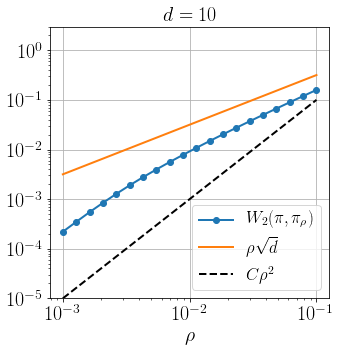

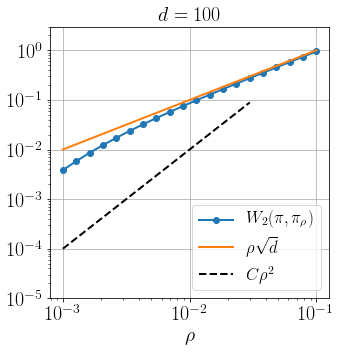

In [79]:
# 2-Wasserstein distance ===========================

# Build the covariance matrix Sigma -----------------------
D = [10,100]
R = np.logspace(-3,-1,20)
W2_real = np.zeros((len(D),len(R)))
W2_bound = np.zeros((len(D),len(R)))

for k in range(len(D)):
    
    d = D[k]
    
    # Sigma
    Sigma = np.zeros((d,d))
    a = 1.5
    eps = 1e-6
    s = np.linspace(-3,3,num=d)
    for i in range(d):
        for j in range(d):
            if i == j:
                Sigma[i,j] = 2 + eps
            else:
                Sigma[i,j] = 2 * np.exp(-(s[i]-s[j])**2 / (2 * a**2))
                
    for l in range(len(R)):
        
        rho = R[l]
        Sigma_rho = Sigma + rho**2 * np.eye(d)
        W2_real[k,l] = np.sqrt(np.trace(Sigma + Sigma_rho - 2 * real(sqrtm((real(sqrtm(Sigma)).dot(Sigma_rho)).dot(real(sqrtm(Sigma)))))))
        W2_bound[k,l] = rho * np.sqrt(d) 
        
# Plot for d = 10 -----------------------
k = 0
lim = 20
plt.figure()
plt.loglog(R[:lim],W2_real[k,:lim],'-o',lw=2,label=r'$W_2(\pi,\pi_{\rho})$')
plt.loglog(R[:lim],W2_bound[k,:lim],lw=2,label=r'$\rho\sqrt{d}$')
plt.loglog(R[:lim],10*R[:lim]**2,'--',color='black',lw=2,label=r'$C\rho^2$')
plt.grid()
plt.title(r'$d=10$',size=20)
plt.xlabel(r'$\rho$',size=20)
plt.legend(loc=4,prop={'size': 17})
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylim((1e-5,3))

# Plot for d = 100 -----------------------
k = 1
lim = 20
plt.figure()
plt.loglog(R[:lim],W2_real[k,:lim],'-o',lw=2,label=r'$W_2(\pi,\pi_{\rho})$')
plt.loglog(R[:lim],W2_bound[k,:lim],lw=2,label=r'$\rho\sqrt{d}$')
plt.loglog(R[:lim-5],100*R[:lim-5]**2,'--',color='black',lw=2,label=r'$C\rho^2$')
plt.grid()
plt.title(r'$d=100$',size=20)
plt.xlabel(r'$\rho$',size=20)
plt.legend(prop={'size': 17})
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylim((1e-5,3))

#### Figures for the total variation distance

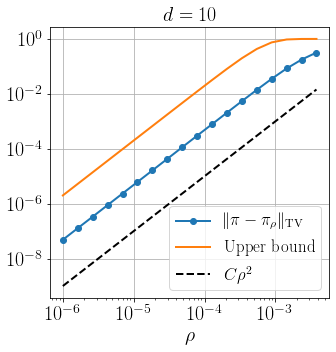

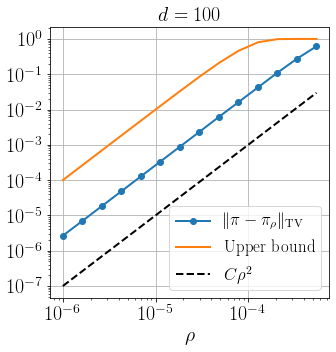

In [92]:
# Total variation distance ===========================

# Build the covariance matrix Sigma -----------------------
D = [10,100]
R = np.logspace(-6,-2,20)        

TV_bound = np.zeros((len(D),len(R)))
TV_real = np.zeros((len(D),len(R)))

# Get samples from pi
for k in range(len(D)):
    
    d = D[k]
    
    # Sigma
    Sigma = np.zeros((d,d))
    a = 1.5
    eps = 1e-6
    s = np.linspace(-3,3,num=d)
    for i in range(d):
        for j in range(d):
            if i == j:
                Sigma[i,j] = 2 + eps
            else:
                Sigma[i,j] = 2 * np.exp(-(s[i]-s[j])**2 / (2 * a**2))


    for l in range(len(R)):
        rho = R[l]
        Sigma_rho = Sigma + (rho**2) * np.eye(d)
        size = 100000
        theta_pi = sampler_factorization(mu=np.zeros(d),A=Sigma,mode="covariance",method="Cholesky",size=size)

        Q_rho = np.linalg.inv(Sigma_rho)
        Q = np.linalg.inv(Sigma)

        TV_real[k,l] = (0.5 / size) \
                        * np.sum(np.abs(1 - np.sqrt(np.linalg.det(Sigma.dot(Q_rho))) \
                        * np.exp(- 0.5 * (theta_pi * ((Q_rho-Q).dot(theta_pi))).sum(axis=0))))
        M1 = np.linalg.norm(np.linalg.inv(Sigma),2)
        M2 = (1 / size) * np.sum(np.linalg.norm(Q.dot(theta_pi),2,0)**2)
        TV_bound[k,l] = 1 - (1 - (rho**4 * M1 * M2) / (1 + 2 * rho**2 * M1) ) / (1 + 2 * rho**2 * M1)**(d/2)
        
# Plot for d = 10 -----------------------
k = 0
lim = 18
plt.figure()
plt.loglog(R[:lim],TV_real[k,:lim],'-o',lw=2,label=r'$\|\pi-\pi_{\rho}\|_{\mathrm{TV}}$')
plt.loglog(R[:lim],TV_bound[k,:lim],lw=2,label=r'Upper bound')
plt.loglog(R[:lim],1e3*R[:lim]**2,'--',color='black',lw=2,label=r'$C\rho^2$')
plt.grid()
plt.title(r'$d=10$',size=20)
plt.xlabel(r'$\rho$',size=20)
plt.legend(prop={'size': 17})
plt.xticks(size=20)
plt.yticks(size=20)

# Plot for d = 100 -----------------------
k = 1
lim = 14
plt.figure()
plt.loglog(R[:lim],TV_real[k,:lim],'-o',lw=2,label=r'$\|\pi-\pi_{\rho}\|_{\mathrm{TV}}$')
plt.loglog(R[:lim],TV_bound[k,:lim],lw=2,label=r'Upper bound')
plt.loglog(R[:lim],1e5*R[:lim]**2,'--',color='black',lw=2,label=r'$C\rho^2$')
plt.grid()
plt.title(r'$d=100$',size=20)
plt.xlabel(r'$\rho$',size=20)
plt.legend(prop={'size': 17})
plt.xticks(size=20)
plt.yticks(size=20)

## Figure 5

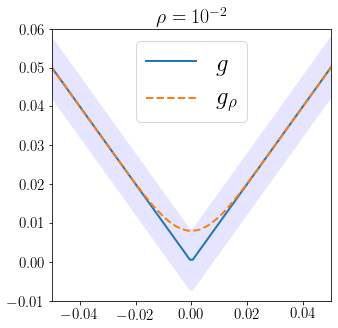

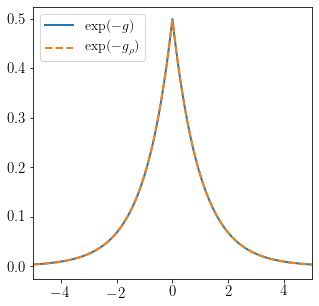

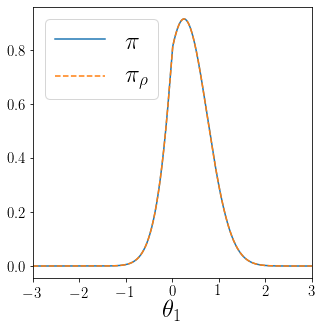

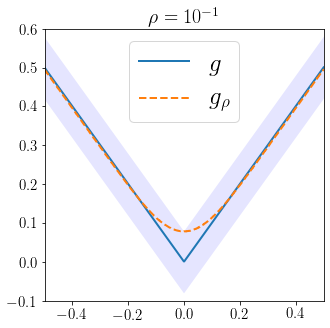

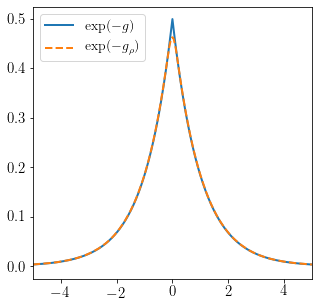

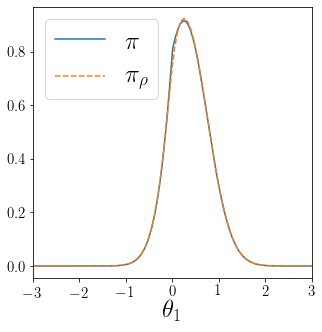

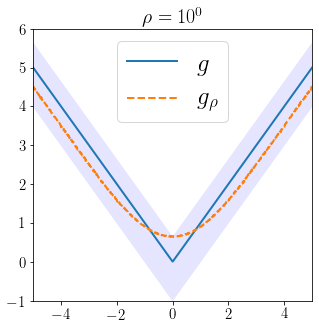

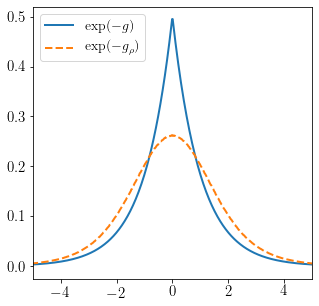

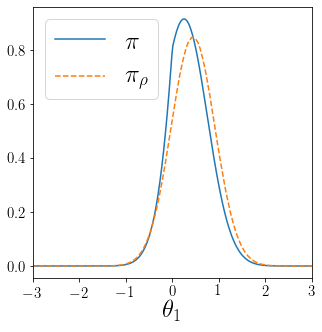

In [97]:
# Parameters -----------------------
d = 1 # dimension of the problem 
tau = 1 # regularization parameter
Lg = tau * np.sqrt(d) # Lipschitz constant of the function g
rho = [0.01,0.1,1] # Hyperparameter of the split scheme
s = 100000 # number of samples

for r in range(len(rho)):

    # Functions -----------------------
    x = np.linspace(-5,5,num=10000)
    x1 =  np.linspace(-5,5,num=1000)
    g = tau * np.abs(x)
    g1 = tau * np.abs(x1)
    g_rho = []
    g_rho1 = []
    g_rho2 = []

    for i in range(len(x)):
        eps = np.random.normal(loc=x[i],scale=rho[r],size=s)
        S = (1/len(eps)) * sum(np.exp(-tau * np.abs(eps)))
        g_rho.append(S)
    
    for i in range(len(x1)):
        eps = np.random.normal(loc=x1[i],scale=rho[r],size=int(s/10))
        S = (1/len(eps)) * sum(np.exp(-tau * np.abs(eps)))
        g_rho1.append(S)

    # Bounds -----------------------
    A = np.log(special.gamma(1+d/2) * 2**(d/2)) - np.log(float(d * special.gamma(d) * np.exp(0.25*(Lg**2)*(rho[r]**2))*mp.pcfd(-d,-Lg*rho[r])))
    B = np.log(special.gamma(1+d/2) * 2**(d/2)) - np.log(float(d * special.gamma(d) * np.exp(0.25*(Lg**2)*(rho[r]**2))*mp.pcfd(-d,Lg*rho[r])))

    # Plot potentials -----------------------
    plt.figure()
    if r == 2:
        plt.plot(x1,g1,label=r"$g$",lw=2)
        plt.plot(x1,-np.log(g_rho1),'--',label=r"$g_{\rho}$",lw=2)
        B1 = g1 + A
        B2 = g1 + B
        plt.fill_between(x1, B1, B2, facecolor='blue', alpha='0.1')
    else:
        plt.plot(x,g,label=r"$g$",lw=2)
        plt.plot(x,-np.log(g_rho),'--',label=r"$g_{\rho}$",lw=2)
        B1 = g + A
        B2 = g + B
        plt.fill_between(x, B1, B2, facecolor='blue', alpha='0.1')
    plt.legend(loc='upper center',prop={'size': 25})
    plt.xlim((-rho[r] * 5,rho[r] * 5))
    plt.ylim((-rho[r],rho[r] * 6))
    plt.tick_params(labelsize=15)
    plt.title(r'$\rho = 10^{%i}$'%(np.log10(rho[r])),size=20)

    # Plot prior distributions -----------------------
    fig, ax1 = plt.subplots()
    if r == 2:
        x = np.linspace(-10,10,num=1000)
        g_rho = []
        for i in range(len(x)):
            eps = np.random.normal(loc=x[i],scale=rho[r],size=s)
            S = (1/len(eps)) * sum(np.exp(-tau * np.abs(eps)))
            g_rho.append(S)   
        f = lambda t: np.exp(-tau*np.abs(t))
        I1,error = integrate.quad(f,-100,100)
        I2 = np.trapz(np.exp(np.log(g_rho)), x)
        g = tau * np.abs(x)
        plt.plot(x,np.exp(-g)/I1,label=r"$\exp(-g)$",lw=2)
        plt.plot(x,np.exp(np.log(g_rho))/I2,'--',label=r"$\exp(-g_{\rho})$",lw=2)
    else:
        x = np.linspace(-10,10,num=10000)
        g_rho = []
        for i in range(len(x)):
            eps = np.random.normal(loc=x[i],scale=rho[r],size=s)
            S = (1/len(eps)) * sum(np.exp(-tau * np.abs(eps)))
            g_rho.append(S)   
        f = lambda t: np.exp(-tau*np.abs(t))
        I1,error = integrate.quad(f,-100,100)
        I2 = np.trapz(np.exp(np.log(g_rho)), x)
        g = tau * np.abs(x)
        plt.plot(x,np.exp(-g)/I1,label=r"$\exp(-g)$",lw=2)
        plt.plot(x,np.exp(np.log(g_rho))/I2,'--',label=r"$\exp(-g_{\rho})$",lw=2)
    plt.xlim(-5,5)
    plt.legend(loc='upper left',prop={'size': 14})
    plt.tick_params(labelsize=15)
    
    # Plot posterior distributions -----------------------
    f1 = (1/2)*(2*x-1)**2
    g = tau * np.abs(x) 
    f = lambda t: np.exp(-(1/2)*(2*t-1)**2-tau*np.abs(t))
    I1,error = integrate.quad(f,-100,100)
    I2 = np.trapz(g_rho*np.exp(-f1),x)

    fig, ax1 = plt.subplots()
    plt.plot(x,np.exp(-g-f1)/I1,label=r"$\pi$")
    plt.plot(x,g_rho*np.exp(-f1)/I2,'--',label=r"$\pi_{\rho}$")
    plt.xlim((-3,3))
    plt.legend(loc='upper left',prop={'size': 25})
    plt.tick_params(labelsize=15)
    plt.xlabel(r"$\theta_1$",size=25)

## Table 2

In [12]:
# Parameters -----------------------
sigma = 1
rho = [0.001,0.01,0.1,1] 
alpha = 0.05

for r in range(len(rho)):
    

    # Functions -----------------------
    x = np.linspace(-50,50,num=10000)
    f1 = (1/2)*(2*x-1)**2
    g = tau * np.abs(x)
    g_rho = []

    for i in range(len(x)):
        eps = np.random.normal(loc=x[i],scale=rho[r],size=s)
        S = (1/len(eps)) * sum(np.exp(-tau * np.abs(eps)))
        g_rho.append(S)

    # 95% credibility intervals under \pi -----------------------
    f = lambda t: np.exp(-tau*np.abs(t) -(1/2)*(2*t-1)**2)
    I1,error = integrate.quad(f,-100,100)
    x = np.linspace(-50,50,num=10000)
    pxx = []
    for t in range(len(x)):
        pxx.append(f(x[t]))

    const = sum(pxx)
    idx_pxx = np.argsort(pxx)
    idx_pxx = idx_pxx[::-1]
    pxx2 = np.sort(pxx)
    pxx2 = pxx2[::-1]
    pxx2 = pxx2 / const
    crit1 = np.sort(x[idx_pxx[np.where(np.cumsum(pxx2) < 1-alpha)]])
    print('')
    display(Latex(r'---- $\rho = %1.3f$ ----' %rho[r]))
    display(Latex(r'Credibility interval under the initial posterior $\pi$'))
    print(r'Lower bound of the interval: ' + str(np.min(crit1)))
    print(r'Upper bound of the interval: ' + str(np.max(crit1)))

    # 95% credibility intervals under pi_{\rho} -----------------------
    pxx = []
    for t in range(len(x)):
        pxx.append(np.exp(np.log(g_rho[t])-(1/2)*(2*x[t]-1)**2))    

    const = sum(pxx)
    idx_pxx = np.argsort(pxx)
    idx_pxx = idx_pxx[::-1]
    pxx2 = np.sort(pxx)
    pxx2 = pxx2[::-1]
    pxx2 = pxx2 / const
    crit2 = np.sort(x[idx_pxx[np.where(np.cumsum(pxx2) < 1-alpha)]])
    display(Latex(r'Credibility interval under the approximate posterior $\pi_{\rho}$'))
    print(r'Lower bound of the interval: ' + str(np.min(crit2)))
    print(r'Upper bound of the interval: ' + str(np.max(crit2)))

    # Real coverage -----------------------
    I_cred,error = integrate.quad(f,np.min(crit2),np.max(crit2))
    coverage = I_cred/I1
    print(r'Coverage')
    print(coverage)

    # Bounds on the coverage -----------------------
    M_rho = (special.gamma(d/2)*2**(d/2-1))/(special.gamma(d)*np.exp(Lg**2 * rho[r]**2 /4))
    L_rho = (1-alpha)*M_rho/mp.pcfd(-d,-Lg*rho[r])
    U_rho = (1-alpha)*M_rho/mp.pcfd(-d,Lg*rho[r])
    display(Latex(r'Theoretical credibility interval under the approximate posterior $\pi_{\rho}$'))
    print(r'Lower bound of the interval: ' + str(L_rho))
    print(r'Upper bound of the interval: ' + str(U_rho))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Lower bound of the interval: -0.46504650465045927
Upper bound of the interval: 1.2351235123512367


<IPython.core.display.Latex object>

Lower bound of the interval: -0.46504650465045927
Upper bound of the interval: 1.2351235123512367
Coverage
0.9485476046009533


<IPython.core.display.Latex object>

Lower bound of the interval: 0.949242139478796
Upper bound of the interval: 0.950758120098771



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Lower bound of the interval: -0.46504650465045927
Upper bound of the interval: 1.2351235123512367


<IPython.core.display.Latex object>

Lower bound of the interval: -0.46504650465045927
Upper bound of the interval: 1.2351235123512367
Coverage
0.9485476046009533


<IPython.core.display.Latex object>

Lower bound of the interval: 0.94243309832365
Upper bound of the interval: 0.957592859428696



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Lower bound of the interval: -0.46504650465045927
Upper bound of the interval: 1.2351235123512367


<IPython.core.display.Latex object>

Lower bound of the interval: -0.46504650465045927
Upper bound of the interval: 1.2351235123512367
Coverage
0.9485476046009533


<IPython.core.display.Latex object>

Lower bound of the interval: 0.87552159221826
Upper bound of the interval: 1.02707413855682



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Lower bound of the interval: -0.46504650465045927
Upper bound of the interval: 1.2351235123512367


<IPython.core.display.Latex object>

Lower bound of the interval: -0.47504750475047075
Upper bound of the interval: 1.3651365136513647
Coverage
0.9630316463889953


<IPython.core.display.Latex object>

Lower bound of the interval: 0.342430453996119
Upper bound of the interval: 1.81589992278458


## Figure 2 in supplementary material

Text(0.5, 0, 'y-t')

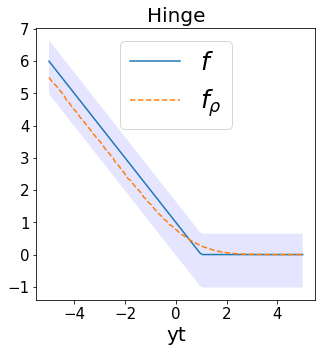

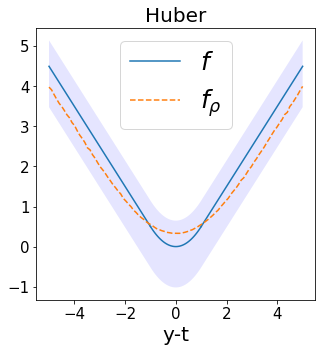

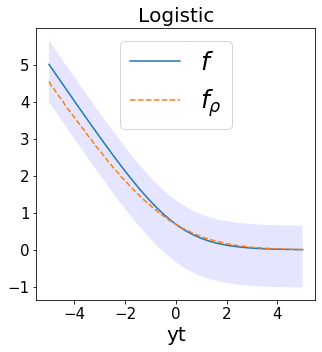

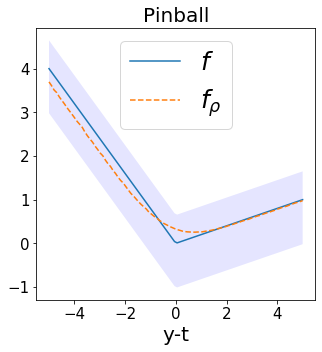

In [13]:
# Parameters -----------------------
d = 1 # dimension of the problem 
tau = 1 # regularization parameter
Lg = tau # Lipschitz constant of the function g
rho = 1 # Hyperparameter of the split scheme
s = 10000 # number of samples
alpha = 0.05
a = -5
b = 5

# Hinge ===========================

# Functions -----------------------
x = np.linspace(a,b,num=100)
g = tau * np.maximum(0,1-x)
g_rho = []

for i in range(len(x)):
    eps = np.random.normal(loc=x[i],scale=rho,size=s)
    S = (1/len(eps)) * sum(np.exp(-tau * np.maximum(0,1-eps)))
    g_rho.append(S)
    
# Bounds -----------------------
A = np.log(special.gamma(1+d/2) * 2**(d/2)) - np.log(float(d * special.gamma(d) * np.exp(0.25*(Lg**2)*(rho**2))*mp.pcfd(-d,-Lg*rho)))
B = np.log(special.gamma(1+d/2) * 2**(d/2)) - np.log(float(d * special.gamma(d) * np.exp(0.25*(Lg**2)*(rho**2))*mp.pcfd(-d,Lg*rho)))

# Plot potentials -----------------------
plt.figure()
plt.plot(x,g,label=r"$f$")
plt.plot(x,-np.log(g_rho),'--',label=r"$f_{\rho}$")
B1 = g + A
B2 = g + B
plt.fill_between(x, B1, B2, facecolor='blue', alpha='0.1')
plt.legend(loc='upper center',prop={'size': 25})
plt.tick_params(labelsize=15)
plt.title('Hinge',size=20)
plt.xlabel(r"yt",size=20)


# Huber ===========================

# Functions -----------------------
delta = 1
x1 = np.linspace(a,-delta,num=100)
g1 = tau * (-x1 - delta/2)
x2 = np.linspace(-delta,delta,num=100)
g2 = (tau/(2*delta)) * x2**2
x3 = np.linspace(delta,b,num=100)
g3 = tau * (x3 - delta/2)

g_rho = []
  
x = np.linspace(a,b,num=100)  
for i in range(len(x)):
    eps = np.random.normal(loc=x[i],scale=rho,size=s)
    mask = eps < - delta
    eps1 = eps[mask]
    S1 = sum(np.exp(-tau * (-eps1 - delta/2)))
    mask = (-delta <= eps) & (eps <= delta)
    eps1 = eps[mask]
    S1 = S1 + sum(np.exp(-(tau/(2*delta)) * eps1**2))
    mask = eps > delta
    eps1 = eps[mask]
    S1 = S1 + sum(np.exp(-tau * (eps1 - delta/2)))
    S = (1/len(eps)) * S1
    g_rho.append(S)
    
# Bounds -----------------------
A = np.log(special.gamma(1+d/2) * 2**(d/2)) - np.log(float(d * special.gamma(d) * np.exp(0.25*(Lg**2)*(rho**2))*mp.pcfd(-d,-Lg*rho)))
B = np.log(special.gamma(1+d/2) * 2**(d/2)) - np.log(float(d * special.gamma(d) * np.exp(0.25*(Lg**2)*(rho**2))*mp.pcfd(-d,Lg*rho)))

# Plot potentials -----------------------
plt.figure()
plt.plot(x1,g1,label=r"$f$")
plt.plot(x2,g2,color='C0')
plt.plot(x3,g3,color='C0')
plt.plot(x,-np.log(g_rho),'--',label=r"$f_{\rho}$", color = 'C1')
B1 = g1 + A
B2 = g1 + B
plt.fill_between(x1, B1, B2, facecolor='blue', alpha='0.1')
B1 = g2 + A
B2 = g2 + B
plt.fill_between(x2, B1, B2, facecolor='blue', alpha='0.1')
B1 = g3 + A
B2 = g3 + B
plt.fill_between(x3, B1, B2, facecolor='blue', alpha='0.1')
plt.legend(loc='upper center',prop={'size': 25})
plt.tick_params(labelsize=15)
plt.title('Huber',size=20)
plt.xlabel(r"y-t",size=20)

# Logistic ===========================

# Functions -----------------------
x = np.linspace(a,b,num=100)
g = tau * np.log(1+np.exp(-x))
g_rho = []

for i in range(len(x)):
    eps = np.random.normal(loc=x[i],scale=rho,size=s)
    S = (1/len(eps)) * sum(np.exp(-tau * np.log(1+np.exp(-eps))))
    g_rho.append(S)
    
# Bounds -----------------------
A = np.log(special.gamma(1+d/2) * 2**(d/2)) - np.log(float(d * special.gamma(d) * np.exp(0.25*(Lg**2)*(rho**2))*mp.pcfd(-d,-Lg*rho)))
B = np.log(special.gamma(1+d/2) * 2**(d/2)) - np.log(float(d * special.gamma(d) * np.exp(0.25*(Lg**2)*(rho**2))*mp.pcfd(-d,Lg*rho)))

# Plot potentials -----------------------
plt.figure()
plt.plot(x,g,label=r"$f$")
plt.plot(x,-np.log(g_rho),'--',label=r"$f_{\rho}$")
B1 = g + A
B2 = g + B
plt.fill_between(x, B1, B2, facecolor='blue', alpha='0.1')
plt.legend(loc='upper center',prop={'size': 25})
plt.tick_params(labelsize=15)
plt.title('Logistic',size=20)
plt.xlabel(r"yt",size=20)

# Quantile ===========================

# Functions -----------------------
x = np.linspace(a,b,num=100)
eta = 0.2
g = tau * (eta*np.maximum(0,x) + (1-eta)*np.maximum(0,-x))
g_rho = []

for i in range(len(x)):
    eps = np.random.normal(loc=x[i],scale=rho,size=s)
    S = (1/len(eps)) * sum(np.exp(-tau * (eta*np.maximum(0,eps) + (1-eta)*np.maximum(0,-eps))))
    g_rho.append(S)
    
# Bounds -----------------------
A = np.log(special.gamma(1+d/2) * 2**(d/2)) - np.log(float(d * special.gamma(d) * np.exp(0.25*(Lg**2)*(rho**2))*mp.pcfd(-d,-Lg*rho)))
B = np.log(special.gamma(1+d/2) * 2**(d/2)) - np.log(float(d * special.gamma(d) * np.exp(0.25*(Lg**2)*(rho**2))*mp.pcfd(-d,Lg*rho)))

# Plot potentials -----------------------
plt.figure()
plt.plot(x,g,label=r"$f$")
plt.plot(x,-np.log(g_rho),'--',label=r"$f_{\rho}$")
B1 = g + A
B2 = g + B
plt.fill_between(x, B1, B2, facecolor='blue', alpha='0.1')
plt.legend(loc='upper center',prop={'size': 25})
plt.tick_params(labelsize=15)
plt.title('Pinball',size=20)
plt.xlabel(r"y-t",size=20)

## Figure 3 in supplementary material

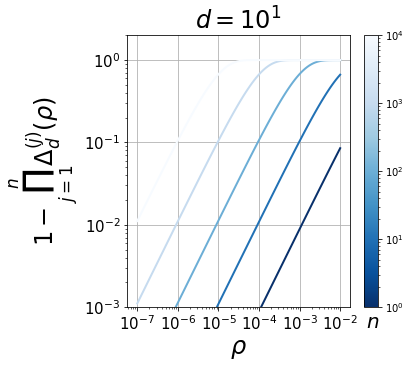

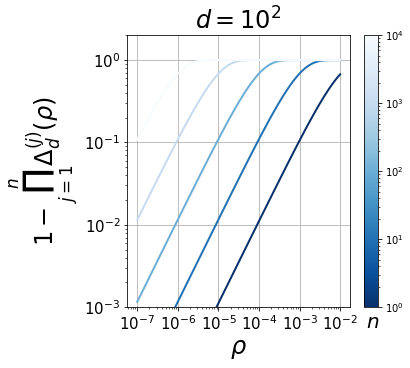

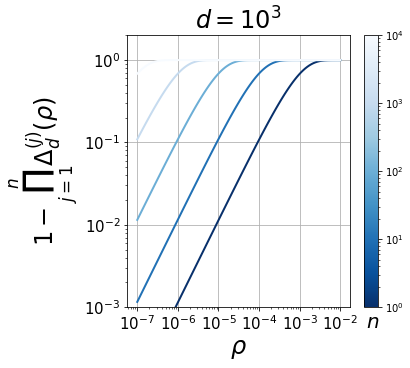

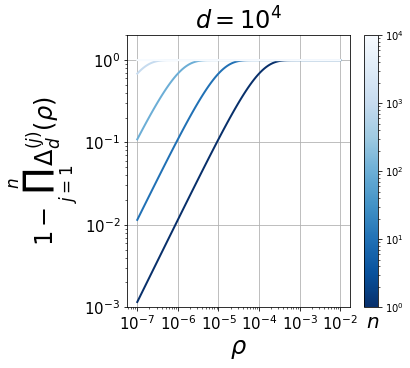

In [18]:
# Parameters -----------------------
rho = np.logspace(-7,-2,1e2)
N = [1,1e1,1e2,1e3,1e4]
D = [10,1e2,1e3,1e4]

# Color rendering -----------------------
normc = mpl.colors.LogNorm(np.min(N),np.max(N))
colors = mpl.cm.Blues_r
col = cm.Blues_r(np.logspace(1,6,100))
s = mpl.cm.ScalarMappable(cmap=colors, norm=normc)
s.set_array([])

# Plot upper bounds -----------------------
for d in range(len(D)):
    plt.figure()
    res = np.zeros((len(N),len(rho)))
    for j in range(len(N)):
        UB = []
        Lg = np.mean(np.linalg.norm(np.random.uniform(0,1,(int(N[j]),int(D[d]))),2,1)) # Lipschitz constant of the function g
        
        for i in range(len(rho)):
            UB.append(1 - (mp.pcfd(-D[d],Lg*rho[i]) / mp.pcfd(-D[d],-Lg*rho[i]))**N[j])
        res[j,] = UB   
        plt.plot(rho, UB, lw=2, color=colors(normc(N[j])))
      
    cb1 = plt.colorbar(s,ticklocation = 'left')
    plt.ylim(1e-3,2)
    cb1.ax.text(3.3,0.5,r"$n$", rotation=0,size=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid()
    plt.xlabel(r"$\rho$",size=24)
    plt.ylabel(r"$1 - \prod_{j=1}^n \Delta_d^{(j)}(\rho)$",size=24)
    plt.title(r"$d = 10^{%s}$"% int(np.log10(D[d])),size=24)

## Figure 6

Relative residual between exact and approximate MMSEs = 0.026308


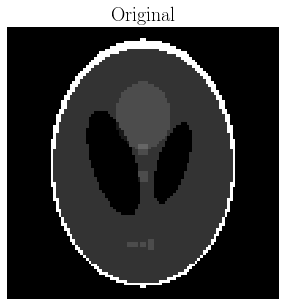

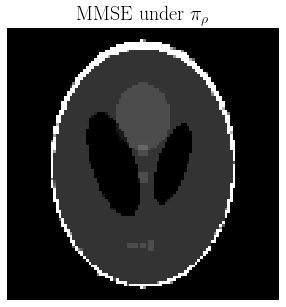

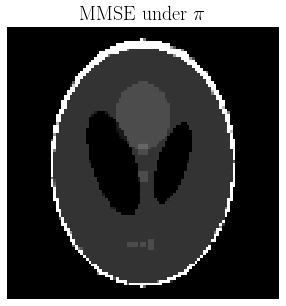

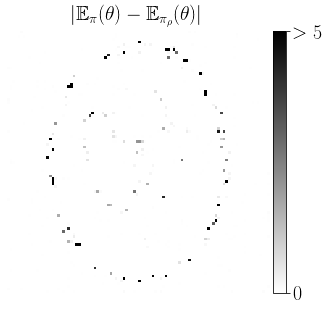

In [151]:
# Load data -----------------------
X = loadmat('inpainting.mat')

# Plot original image -----------------------
plt.figure()
plt.imshow(X['theta'],cmap='gray')
plt.axis('off')
plt.title('Original',size=20)

# Plot MMSEs and compute residual -----------------------
plt.figure()
plt.imshow(X['MMSE'],cmap='gray')
plt.axis('off')
plt.title(r'MMSE under $\pi_{\rho}$',size=20)

plt.figure()
plt.imshow(X['MMSE_exact'],cmap='gray')
plt.axis('off')
plt.title(r'MMSE under $\pi$',size=20)

plt.figure()
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.abs(X['MMSE'] - X['MMSE_exact']),cmap='gray_r')
ax.axis('off')
im.set_clim(0,5)
cbar = plt.colorbar(im,cax=cax,ticks=[0,5])
cbar.ax.set_yticklabels(['0', r'$>$ 5'])  # vertically oriented colorbar
cbar.ax.tick_params(labelsize=20) 
ax.set_title(r'$|E_{\pi}(\theta) - E_{\pi_{\rho}}(\theta)|$',size=20)

res = np.linalg.norm(np.abs(np.reshape(X['MMSE'],[10000,]) - np.reshape(X['MMSE_exact'],[10000,])) \
                    / np.linalg.norm(np.reshape(X['MMSE_exact'],[10000,])))
print('Relative residual between exact and approximate MMSEs = %f'%res)

## Figure 7

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
        1.e+05, 1.e+06]), <a list of 10 Text xticklabel objects>)

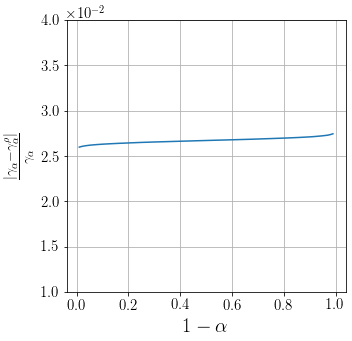

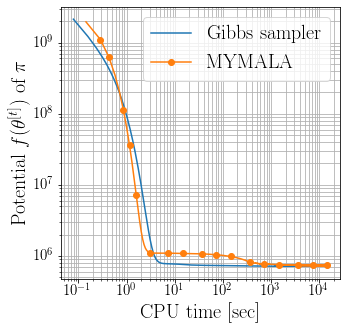

In [154]:
# Plot residuals -----------------------
plt.figure()
plt.plot(np.reshape(X['A'],[100,]),np.abs(np.reshape(X['eta'],[100,]) - np.reshape(X['eta_exact'],[100,])) \
         / np.reshape(X['eta_exact'],[100,]))
plt.ylabel(r'$\frac{|\gamma_{\alpha} - \gamma_{\alpha}^{\rho}|}{\gamma_{\alpha}}$',size=20)
plt.xlabel(r'$1-\alpha$',size=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
axes = plt.gca()
axes.yaxis.offsetText.set_fontsize(15)
plt.ylim((0.01,0.04))
plt.grid()

# Plot potential function w.r.t. the number of iterations -----------------------
t = np.linspace(1,99999,99998)
time_Gibbs = t * 0.079
time_MYMALA = t * 0.144
mark_vec = [1,2,5,7,10,20,50,100,250,500,1000,2500,5000,10000,25000,50000,99997]
plt.figure()
plt.plot(time_Gibbs,np.reshape(X['f'][1:],[99998,]),label="Gibbs sampler")
plt.plot(time_MYMALA,np.reshape(X['f_exact'][1:],[99998,]),'o-',markevery=mark_vec,label="MYMALA")
plt.ylabel(r'Potential $f(\theta^{[t]})$ of $\pi$',size=20)
plt.xlabel(r'CPU time [sec]',size=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(prop={'size': 20})
plt.grid(which='both')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)